## Machine Learning

In [2]:
# pip install scikit-surprise
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

import gc

In [3]:
df1 = pd.read_parquet(('processed_data/all.parquet'))
title = pd.read_parquet('processed_data/title.parquet')

In [84]:
title.tail(2)

,movieId,title
22996,ns8806,zoom
22997,ns8807,zubaan


In [74]:
df1.shape
df1['userId'].max()

270896

In [46]:
reader = Reader()
# N_filas = 100000 # Limita el dataset a N_filas
# data = Dataset.load_from_df(df1[['userId', 'movieId', 'score']][:N_filas], reader)
data = Dataset.load_from_df(df1[['userId', 'movieId', 'score']], reader)

In [47]:
# Separa los datos, instancia el modelo SVD, entrena y predice.
trainset, testset = train_test_split(data, test_size=.25)
model = SVD()
model.fit(trainset)
predictions = model.test(testset)

In [48]:
from surprise import accuracy   
accuracy.rmse(predictions)      # Evalua la precision del modelo

RMSE: 1.0016


1.0015579784563007

In [49]:
# Toma un usuario para hacerle una recomendación
usuario = 2
scored = 4   # Toma películas a las que haya calificado con 5 estrellas
df_user = df1[(df1['userId'] == usuario) & (df1['score'] >= scored)] # Filtra por usuario y score > rating
# df_user = df_user.reset_index(drop=True) # Resetea el index
# df_user = df_user.drop('Unnamed: 0', axis=1)
df_user.tail(3)

,userId,movieId,score,platform,title
44,2,ds139,4.0,disney,beverly hills chihuahua 3: viva la fiesta!
45,2,ds319,4.0,disney,marvel studios legends
46,2,ns7879,5.0,netflix,robotech


In [50]:
usuario_vistas = df1[df1['userId'] == usuario] # Titulos vistos por el usuario seleccionado
usuario_vistas.tail(2)

,userId,movieId,score,platform,title
47,2,as9099,3.0,amazon,squirm
48,2,ns5772,2.0,netflix,murphy's law of love


In [51]:
# Debemos extraer las películas que ya ha visto
usuario_vistas = df1[df1['userId'] == usuario] # Filtro por peliculas que el usuario califico
print(usuario_vistas.shape)

usuario_vistas.movieId

(22, 5)


27    ns5228
28    ns5355
29    hs1581
30    ns4446
31    ns8778
32    ns2462
33     hs589
34    as8906
35    as2307
36    as2200
37    as2064
38    ns3954
39    ns3429
40    ns3522
41    as7276
42    hs1914
43    as9455
44     ds139
45     ds319
46    ns7879
47    as9099
48    ns5772
Name: movieId, dtype: object

In [36]:
title.tail(1)

,movieId,title
22997,ns8807,zubaan


In [52]:
recomendaciones_usuario = title.set_index(['movieId'])  # Establece movieId como indice
recomendaciones_usuario.drop(usuario_vistas.movieId, inplace = True,  errors='ignore') # Elimina las peliculas vistas
recomendaciones_usuario = recomendaciones_usuario.reset_index() # Resetea los indices
recomendaciones_usuario.shape   # Verifica que se eliminaron los titulos vistos

(22976, 2)

In [53]:
# Recomendamos
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['movieId'].apply(lambda x: model.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,movieId,title,Estimate_Score
2808,as2812,coherence,4.296233
4058,as4062,into the sun,4.225385
1614,as1615,more beautiful for having been broken,4.224559
22523,ns8354,the hunt,4.200881
11874,hs767,una familia moderna,4.156250
21657,ns7487,monkey up,4.156040
1476,as1477,no turning back,4.154151
10013,ds355,once upon a time in wonderland,4.142521
20106,ns5936,the square,4.134525
5535,as5539,infected,4.119869


In [54]:
# Evaluamos
accuracy.rmse(predictions)

RMSE: 1.0016


1.0015579784563007

## Optimizacion de hiperparametros

In [32]:
# Optimizacion de hiperparametros
# Realiza una validación cruzada con diferentes valores de un hiperparámetro (número de factores latentes) en un modelo SVD. 
# El objetivo es encontrar el valor de este hiperparámetro que da lugar al menor valor medio de RMSE para un conjunto de datos dado.
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9825  0.9862  0.9861  0.9849  0.0017  
Fit time          1.76    0.78    0.76    1.10    0.47    
Test time         2.36    0.52    0.40    1.09    0.90    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9823  0.9867  0.9860  0.9850  0.0019  
Fit time          0.86    0.87    0.78    0.84    0.04    
Test time         0.60    0.42    0.40    0.47    0.09    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9879  0.9822  0.9869  0.9857  0.0025  
Fit time          0.75    0.78    0.78    0.77    0.02    
Test time         0.60    0.40    0.54    0.51    0.08    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9870  0.9

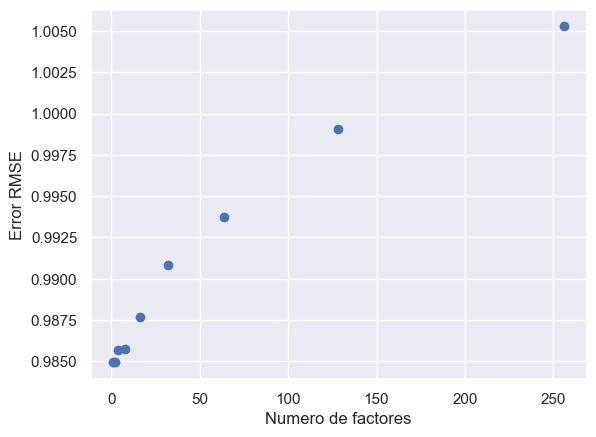

In [33]:
# Ploteamos desempeño según cantidad de factores de SVD

plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [34]:
# Este codigo tiene un tiempo de ejecucion extenso.
# Este código utiliza la función GridSearchCV de la biblioteca surprise para realizar la sintonización de hiperparámetros del modelo SVD.
# param_grid contiene valores para hiperparámetros como el número de factores latentes, número de épocas, tasa de aprendizaje y regularización.
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
# GridSearchCV realiza una búsqueda en cuadrícula sobre todas las posibles combinaciones de hiperparámetros y 
# evalúa el rendimiento del modelo utilizando validación cruzada. 
# En este caso, la métrica de evaluación utilizada es el RMSE, y el parámetro cv especifica el número de pliegues de validación cruzada.
# Al establecer n_jobs en -1, utiliza todos los núcleos de CPU disponibles para acelerar el proceso de optimización de hiperparámetros.
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [35]:
# Observamos performance del mejor modelo

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9809964355734078
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.02}


## Incorporacion de nuevos datos

In [36]:
# Incorporacion de nuevos datos
def load_data(name):
    df = pd.read_csv(name, header = None, names = ['userId','score'], usecols = [0,1])
    
    # En ciertos casos, forzar un tipo de dato hace que se ahorre mucho lugar en memoria.
    df['score'] = df['score']#.astype(float) 
    return df


# df2 = load_data() Aqui se cargan los datos nuevos
# print(df2.shape)

In [37]:
movies_ids_df2 = df2.userId[df2.score.isna()].values
print(movies_ids_df2)
print(len(movies_ids_df2))

movies_ids_df2 = np.arange(4500,len(movies_ids_df2) + 4500)
print(movies_ids_df2)

NameError: name 'df2' is not defined

In [ ]:
df2_nan = pd.DataFrame(pd.isnull(df2.score))
df2_nan = df2_nan[df2_nan['score'] == True]
idx_movies_ids = df2_nan.index.values
print(idx_movies_ids)

In [ ]:
# Agregamos el índice de la última instancia del DataFrame
idx_movies_ids = np.append(idx_movies_ids,df2.shape[0])

In [ ]:
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

In [ ]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df2[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

In [ ]:
df2['movieId'] = columna_movie_id
del columna_movie_id

df2.dropna(inplace = True)
df2['userId'] = df2['userId'].astype(int)
df2['movieId'] = df2['movieId'].astype(np.int16)
df2['score'] = df2['score'].astype(np.int8)

gc.collect()

In [ ]:
### 5.
df = df1.copy()
del df1
df = df.append(df2)
print(df.shape)

In [ ]:
# Corroboramos que estén todas las películas

peliculas_presentes = df.movie_id.unique()
peliculas_presentes

In [ ]:
print((peliculas_presentes - np.arange(1,9210 + 1)).sum())

In [ ]:
# Y asi sucesivamente
switch = False
if switch:
    df.to_parquet('data/ML.parquet', index= False)